In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.utils import plot_model
from datetime import date
import holidays
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from scikeras.wrappers import KerasRegressor
import time

In [2]:
df = pd.read_parquet('data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df['dia_semana'] = df['fecha'].dt.weekday + 1
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)
df.fillna(0.0, inplace=True)

In [3]:
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,dia_semana,holiday
0,2023-11-01,0.0,8.6725,0.0,60.153034,0.0,3,12,2196,232,1,2023,11,1,3,0
1,2023-11-01,1.0,8.5725,0.1,60.344471,0.0,2,12,1521,55,0,2023,11,1,3,0
2,2023-11-01,2.0,8.3225,0.0,62.933163,0.0,3,8,1214,16,0,2023,11,1,3,0
3,2023-11-01,3.0,8.0725,0.1,66.100021,0.0,0,13,854,20,0,2023,11,1,3,0
4,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3,0


In [4]:
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

In [5]:
def generador_X_Y(X, Y, p):
    ''' 
    A partir dos dataframes, X e Y, y los pasos de tiempo, retorna un tensor 3D para X y una array 2D para Y.
    args:
    - X: pandas dataframe, con m filas (muestras) y n columnas (features)
    - Y: pandas dataframe, con m filas (muestras) e y columnas (longitud de vector de respuesta)
    - p (int): número de pasos de tiempo a considerar
    returns:
    - X_reshaped: numpy array de forma (m, p, n)
    - Y_reshaped: numpy array de forma (m, y)
    '''
    
    X_reshaped_list = list()
    Y_rehaped_list = list()

    m = len(X)
    X = np.array(X)
    Y = np.array(Y)

    for i in range(m-p):
        X_reshaped_list.append(X[i:i+p, :])
        Y_rehaped_list.append(Y[i+p-1, :])
    
    X_reshaped = np.array(X_reshaped_list)
    Y_reshaped = np.array(Y_rehaped_list)

    return X_reshaped, Y_reshaped

In [32]:
def crear_modelo(X_reshaped, Y_reshaped, nro_capas_lstm=1, unidades_capa= [50], nro_capas_dense=0, unidades_dense=[0], loss_= 'mse', 
                 act_salida='linear', act_lstm= 'relu', drop_out= 0, learning_r=0.001, act_dense= 'linear'):
    
    # Construimos el modelo LSTM
    model = Sequential()
    if nro_capas_lstm > 1:

        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]), return_sequences=True))
        model.add(Dropout(drop_out))
        for i in range(1, nro_capas_lstm-1):
            model.add(LSTM(units=unidades_capa[i], activation=act_lstm, return_sequences=True))
            model.add(Dropout(drop_out))
        model.add(LSTM(units=unidades_capa[-1], activation=act_lstm))
        
    if nro_capas_lstm == 1:
        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
        model.add(Dropout(drop_out))
    
    if nro_capas_dense > 0:
        for i in range(nro_capas_dense):
            model.add(Dense(units=unidades_dense[i], activation=act_dense))
    
    model.add(Dense(units=Y_reshaped.shape[1], activation=act_salida))

    opt = Adam(learning_rate=learning_r)

    model.compile(optimizer=opt, loss=loss_)  # Compilación del modelo 
    
    #model.summary()

    return model


In [23]:
def construir_modelo(X, Y, nro_pasos=10, nro_capas_lstm=1, unidades_capa= [50], nro_capas_dense=0, unidades_dense=[0], loss_= 'mse', act_salida='linear', 
                     act_lstm= 'relu', act_dense= 'linear', epochs= 50, batch= 32, drop_out= 0, scaler= 'minmax', learning_r=0.1):
    # Normalizar los datos
    if scaler == 'minmax':
        scaler_X = MinMaxScaler()
        scaler_Y = MinMaxScaler()
    if scaler == 'standard':
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

    # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
    X_train_reshaped, Y_train_reshaped = generador_X_Y(X_train, Y_train, nro_pasos)
    X_test_reshaped, Y_test_reshaped = generador_X_Y(X_test, Y_test, nro_pasos)

    # Construimos el modelo LSTM
    model = Sequential()
    if nro_capas_lstm > 1:

        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
        model.add(Dropout(drop_out))
        for i in range(1, nro_capas_lstm-1):
            model.add(LSTM(units=unidades_capa[i], activation=act_lstm, return_sequences=True))
            model.add(Dropout(drop_out))
        model.add(LSTM(units=unidades_capa[-1], activation=act_lstm))
    
    
    if nro_capas_lstm == 1:
        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
        model.add(Dropout(drop_out))
    
    if nro_capas_dense > 0:
        for i in range(nro_capas_dense):
            model.add(Dense(units=unidades_dense[i], activation=act_dense))
    
    model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))

    opt = Adam(learning_rate=learning_r)

    model.compile(optimizer=opt, loss=loss_)  # Compilación del modelo 
    
    model.summary()

    # Entrenamos el modelo y guardamos el historial de entrenamiento
    history = model.fit(X_train_reshaped, Y_train_reshaped, epochs=epochs, batch_size=batch, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

    return model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, history

Vamos a generar una nueva función que haga una cross validation antes de entrenar el modelo a retornar

In [36]:
def construir_modelo_cv(X, Y, nro_pasos=10, nro_capas_lstm=1, unidades_capa= [50], loss_= 'mse', act_salida='linear', act_lstm= 'relu', 
                     epochs= 50, batch= 32, drop_out= 0, scaler= 'minmax', learning_r=0.001, nro_capas_dense=0, unidades_dense=[0], 
                     act_dense= 'linear'):
    # Normalizar los datos
    if scaler == 'minmax':
        scaler_X = MinMaxScaler()
        scaler_Y = MinMaxScaler()
    if scaler == 'standard':
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

    # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
    X_train_reshaped, Y_train_reshaped = generador_X_Y(X_train, Y_train, nro_pasos)
    X_test_reshaped, Y_test_reshaped = generador_X_Y(X_test, Y_test, nro_pasos)

    # Envolvemos el modelo en un estimador de Scikit-Learn
    estimator = KerasRegressor(
        build_fn=crear_modelo,
        X_reshaped=X_train_reshaped,
        Y_reshaped=Y_train_reshaped,
        nro_capas_lstm=nro_capas_lstm,
        unidades_capa=unidades_capa,
        nro_capas_dense = nro_capas_dense,
        unidades_dense = unidades_dense,
        loss_=loss_,
        act_salida= act_salida,
        act_lstm= act_lstm,
        act_dense = act_dense,
        drop_out=drop_out,
        learning_r=learning_r,
        epochs=epochs,
        batch_size=batch,
        verbose=0
    )

    # Usamos el regresor en cross_val_score

    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(estimator, X_train_reshaped, Y_train_reshaped, cv=tscv, scoring='neg_mean_squared_error', verbose=0)

    # entrenamos el modelo

    modelo = crear_modelo(X_train_reshaped, Y_train_reshaped, nro_capas_lstm, unidades_capa, nro_capas_dense, unidades_dense, loss_, 
                    act_salida, act_lstm, drop_out, learning_r, act_dense)
    
    history = modelo.fit(X_train_reshaped, Y_train_reshaped, epochs=epochs, batch_size=batch, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

    if loss_ == 'mse':
        loss = modelo.evaluate(X_test_reshaped, Y_test_reshaped)
    else:
        y_pred = modelo.predict(X_test_reshaped)
        loss = np.mean(tf.keras.losses.mean_squared_error(Y_test_reshaped, y_pred).numpy())

    return modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss

In [9]:
def graficar_curva_aprendizaje(history):
    # Extraemos los valores de la función de pérdida del historial de entrenamiento
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    final_loss = history.history['val_loss'][-1]
    print("Valor final de Loss:", final_loss)
    
    # Graficamos la curva de aprendizaje
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Curva de Aprendizaje')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y):
    Y_test_df = pd.DataFrame(Y_test_reshaped, columns=columnas_Y)
    Y_test_original = scaler_Y.inverse_transform(Y_test_df)
    Y_test_original_df = pd.DataFrame(Y_test_original, columns=columnas_Y)

    Y_predict = modelo.predict(X_test_reshaped)
    Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)

    for i in columnas_Y:
        sns.lineplot(x=Y_predict_original_df.index, y=Y_predict_original_df[i], label='Predicción')
        sns.lineplot(x=Y_test_original_df.index, y=Y_test_original_df[i], label= 'Real')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

Agreguemos una nueva función que genere una evaluación exhaustiva de los parámetros y los almacene en un dataframe:

In [39]:
def evaluar_modelos(X, Y, nro_pasos=25, nro_capas_lstm=[1], unidades_capa= [50], loss_= ['mse', 'mae'], act_salida=['linear'], act_lstm= ['relu'],
                    nro_capas_dense=0, unidades_dense=[0], act_dense= ['linear'], drop_out=0, scaler='minmax'):

    columnas = ['combinacion','nro_pasos', 'nro_capas_lstm', 'unidades_capa', 'nro_capas_dense', 'unidades_dense',  
                'loss_function', 'act_salida', 'act_lstm', 'act_dense', 'loss_value(mse)', 'cv_scores_mean', 'tiempo(s)']

    evaluacion = pd.DataFrame(columns=columnas)
    i = 0
    combinaciones = nro_pasos*len(nro_capas_lstm)*len(loss_)*len(act_salida)*len(act_lstm)
    mejor_score = float('inf')
    mejor_combinacion = 0
    for pasos in range(1,nro_pasos+1):
        for capas in nro_capas_lstm:
            for loss_f in loss_:
                for act_s in act_salida:
                    for act_l in act_lstm:
                        for capas_dense in range(nro_capas_dense):
                            for act_d in act_dense:
                                start_time = time.time()
                                _, _, _, _, _, scores, _, loss = construir_modelo_cv(X, Y, pasos, capas, unidades_capa, loss_f, act_s, act_l,
                                                                                    drop_out=drop_out, nro_capas_dense=capas_dense, 
                                                                                    unidades_dense=unidades_dense, act_dense=act_d,
                                                                                    scaler=scaler)
                                end_time = time.time()
                                tiempo = end_time - start_time
                                unidades_capa_str = ', '.join(map(str, unidades_capa[0:capas]))
                                unidades_dense_str = ', '.join(map(str, unidades_dense[0:capas]))
                                scores_mean = np.mean(-scores)
                                evaluacion.loc[i] = [i+1, pasos, capas, unidades_capa_str, nro_capas_dense, unidades_dense_str,
                                                    loss_f, act_s, act_l, act_d, loss, scores_mean, tiempo]
                                tiempo_promedio = np.mean(evaluacion['tiempo(s)'])
                                i+=1
                                if scores_mean < mejor_score:
                                    mejor_combinacion = i
                                    mejor_score = scores_mean
                                print(f'Finalizada combinación {i} de {combinaciones}. Score= {np.round(scores_mean, 3)}')
                                print(f'Mejor combinación: {mejor_combinacion}. Score: {np.round(mejor_score, 3)}')
                                tiempo_restante = tiempo_promedio * (combinaciones - i) / 60
                                print(f'Quedan {round(tiempo_restante, 2)} minutos.')
    
    return evaluacion

In [11]:
model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, history = construir_modelo(
    X, Y, nro_pasos=20, nro_capas_lstm=3, unidades_capa=[50,30,20], act_lstm= 'sigmoid', scaler='standard'
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            12200     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 30)            9720      
                                                                 
 dropout_1 (Dropout)         (None, 20, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20)                4080      
                                                                 
 dense (Dense)               (None, 5)                 105       
                                                                 
Total params: 26105 (101.97 KB)
Trainable params: 2610

Valor final de Loss: 0.7598069310188293


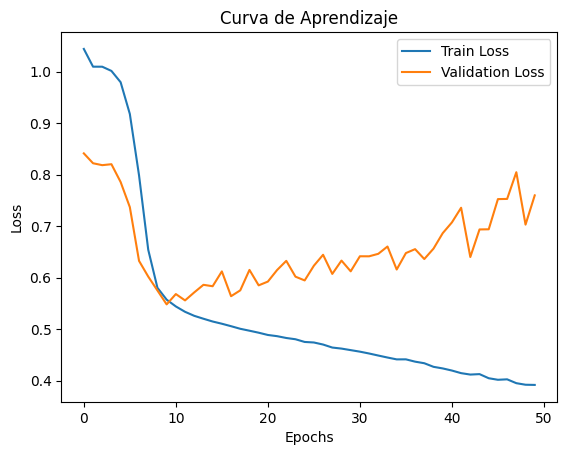

In [12]:
graficar_curva_aprendizaje(history)

Vemos que la curva de aprendizaje diverge de validación diverge, y que la curva de entrenamiento puede seguir bajando. Cambiemos primero la tasa de aprendizaje.

In [17]:
model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, history = construir_modelo(
    X, Y, nro_pasos=20, nro_capas_lstm=3, unidades_capa=[50,30,20], act_lstm= 'sigmoid', scaler='standard',
    learning_r=0.0001
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 50)            12200     
                                                                 
 dropout_4 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 20, 30)            9720      
                                                                 
 dropout_5 (Dropout)         (None, 20, 30)            0         
                                                                 
 lstm_8 (LSTM)               (None, 20)                4080      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
Total params: 26105 (101.97 KB)
Trainable params: 2610

Valor final de Loss: 0.8120893836021423


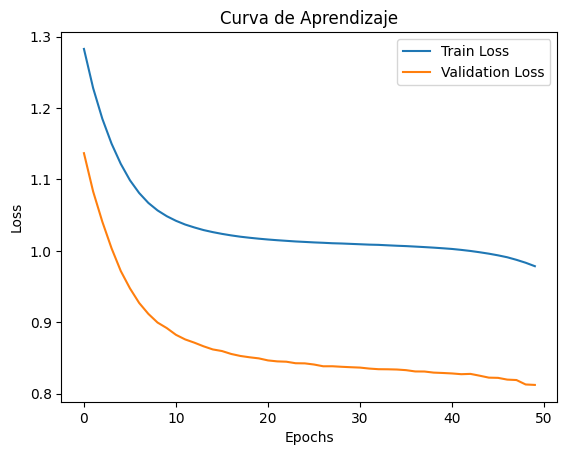

In [18]:
graficar_curva_aprendizaje(history)

Vemos que al disminuir la tasa de aprendizaje mejoran las curvas, pero ahora tenemos la de validación por debajo de la de entrenamiento. Aumentemos la cantidad de epochs:

In [19]:
model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, history = construir_modelo(
    X, Y, nro_pasos=20, nro_capas_lstm=3, unidades_capa=[50,30,20], act_lstm= 'sigmoid', scaler='standard',
    learning_r=0.0001, epochs=100
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 20, 50)            12200     
                                                                 
 dropout_6 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 20, 30)            9720      
                                                                 
 dropout_7 (Dropout)         (None, 20, 30)            0         
                                                                 
 lstm_11 (LSTM)              (None, 20)                4080      
                                                                 
 dense_3 (Dense)             (None, 5)                 105       
                                                                 
Total params: 26105 (101.97 KB)
Trainable params: 2610

Valor final de Loss: 0.5650769472122192


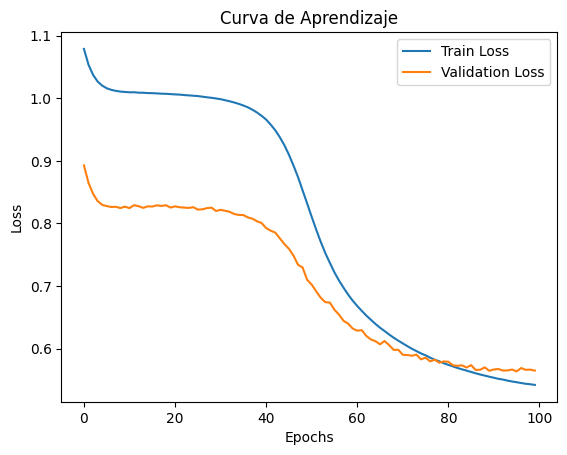

In [20]:
graficar_curva_aprendizaje(history)

Las curvas mejoran, pero no tenemos una buena pérdida final. Grafiquemos para ver como se comportan las predicciones:

9/9 [==============================] - 0s 6ms/step


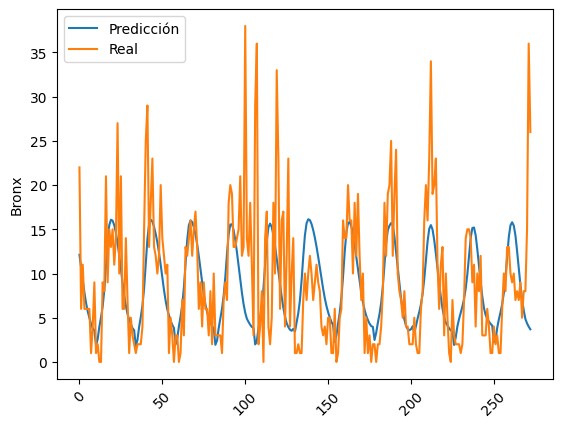

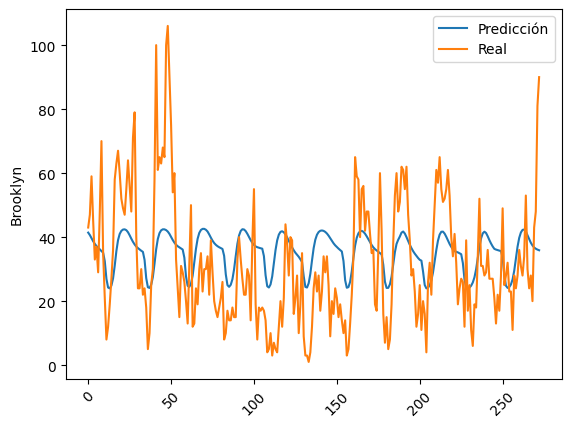

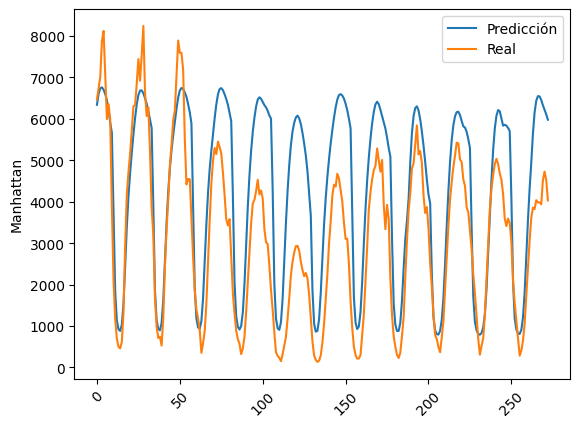

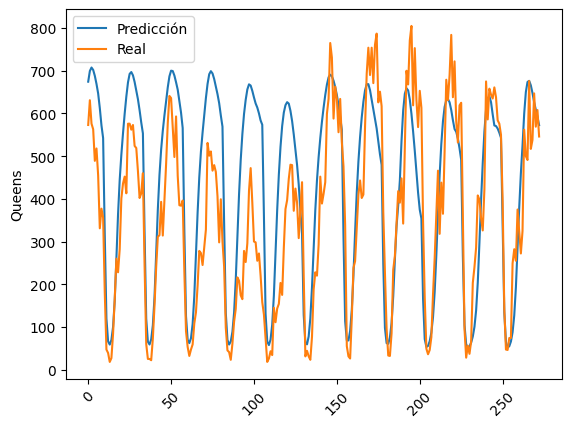

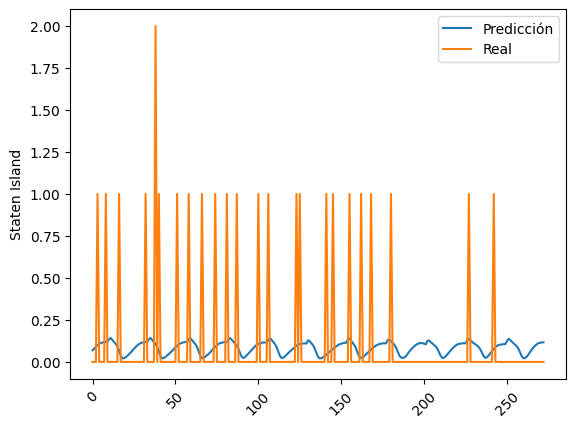

In [21]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, model, scaler_Y)

Probemos ahora escalando con minmax:

In [22]:
model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, history = construir_modelo(
    X, Y, nro_pasos=20, nro_capas_lstm=3, unidades_capa=[50,30,20], act_lstm= 'sigmoid', scaler='minmax',
    learning_r=0.0001, epochs=100
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 50)            12200     
                                                                 
 dropout_8 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 30)            9720      
                                                                 
 dropout_9 (Dropout)         (None, 20, 30)            0         
                                                                 
 lstm_14 (LSTM)              (None, 20)                4080      
                                                                 
 dense_4 (Dense)             (None, 5)                 105       
                                                                 
Total params: 26105 (101.97 KB)
Trainable params: 2610

Valor final de Loss: 0.029366884380578995


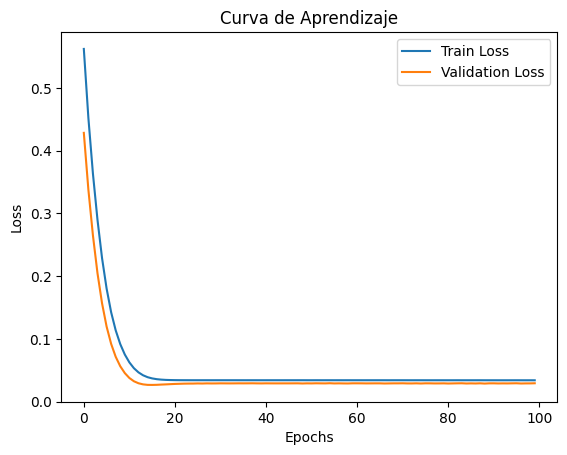

In [23]:
graficar_curva_aprendizaje(history)

Vemos que hay sobreajuste además que con 25 epochs el modelo ya había convergido. Veamos que sucede si agregamos dropout:

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 20, 50)            12200     
                                                                 
 dropout_10 (Dropout)        (None, 20, 50)            0         
                                                                 
 lstm_16 (LSTM)              (None, 20, 30)            9720      
                                                                 
 dropout_11 (Dropout)        (None, 20, 30)            0         
                                                                 
 lstm_17 (LSTM)              (None, 20)                4080      
                                                                 
 dense_5 (Dense)             (None, 5)                 105       
                                                                 
Total params: 26105 (101.97 KB)
Trainable params: 2610

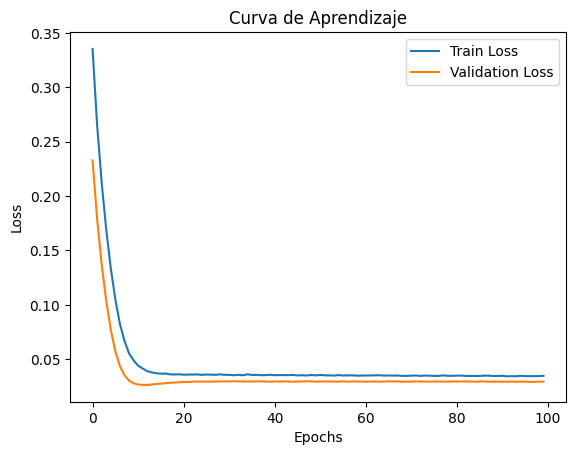

In [24]:
model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, history = construir_modelo(
    X, Y, nro_pasos=20, nro_capas_lstm=3, unidades_capa=[50,30,20], act_lstm= 'sigmoid', scaler='minmax',
    learning_r=0.0001, epochs=100, drop_out=0.2
)
graficar_curva_aprendizaje(history)

Sigue habiendo sobreajuste. Probemos reducir la cantidad de neuronas por capa:

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 20, 30)            4920      
                                                                 
 dropout_14 (Dropout)        (None, 20, 30)            0         
                                                                 
 lstm_22 (LSTM)              (None, 20, 20)            4080      
                                                                 
 dropout_15 (Dropout)        (None, 20, 20)            0         
                                                                 
 lstm_23 (LSTM)              (None, 10)                1240      
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
Total params: 10295 (40.21 KB)
Trainable params: 10295

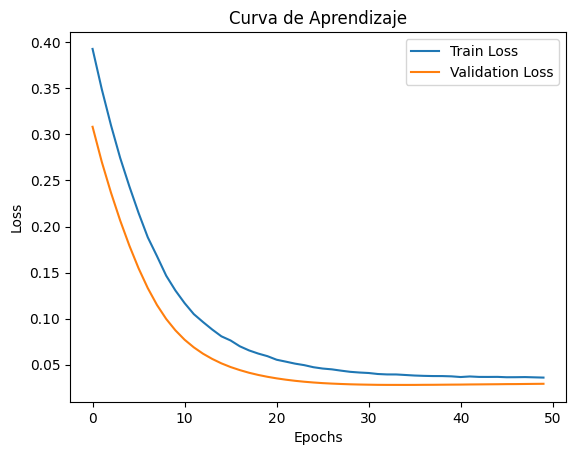

In [26]:
model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, history = construir_modelo(
    X, Y, nro_pasos=20, nro_capas_lstm=3, unidades_capa=[30,20,10], act_lstm= 'sigmoid', scaler='minmax',
    learning_r=0.0001, epochs=50, drop_out=0.2
)
graficar_curva_aprendizaje(history)

Volvamos a modelos de una sola capa LSTM:

In [62]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history = construir_modelo_cv(
    X, Y, nro_pasos=20, nro_capas_lstm=1, act_lstm= 'sigmoid', scaler='minmax',
    learning_r=0.001, epochs=50
)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 50)                12200     
                                                                 
 dropout_32 (Dropout)        (None, 50)                0         
                                                                 
 dense_24 (Dense)            (None, 5)                 255       
                                                                 
Total params: 12455 (48.65 KB)
Trainable params: 12455 (48.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 50)                12200     
                                                            

In [63]:
np.mean(-scores)

0.019580741757198112

9/9 [==============================] - 0s 5ms/step


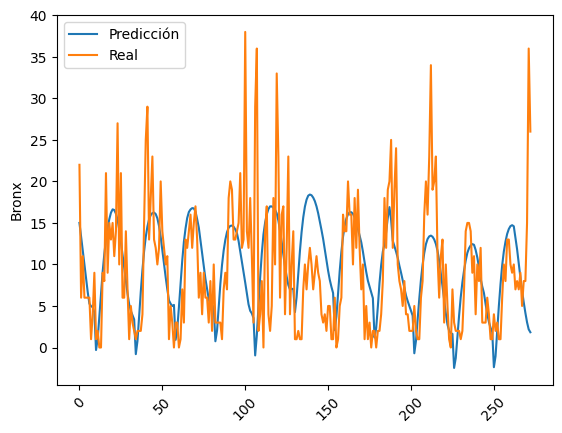

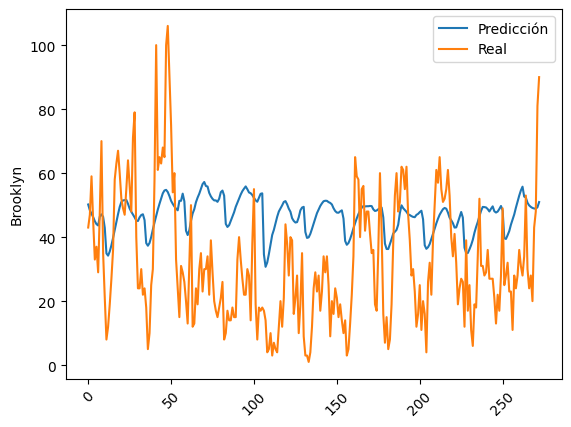

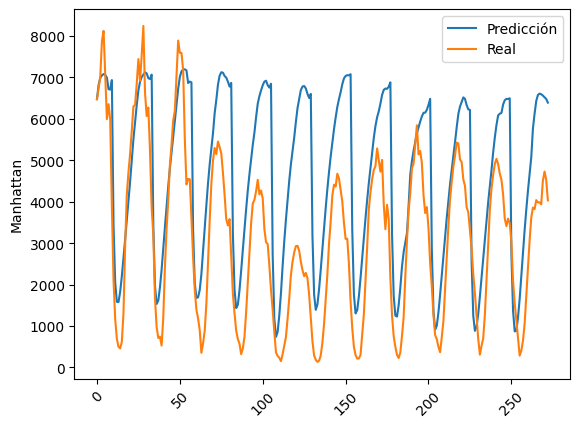

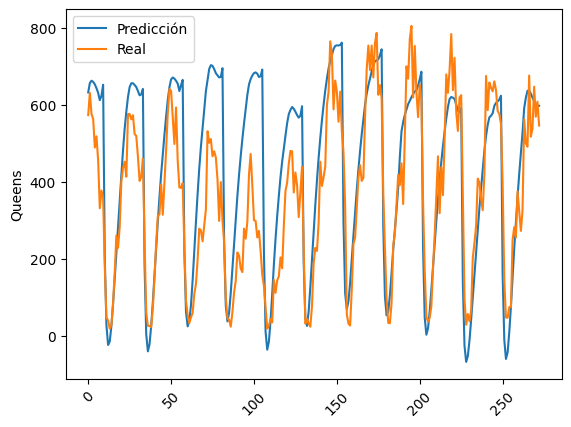

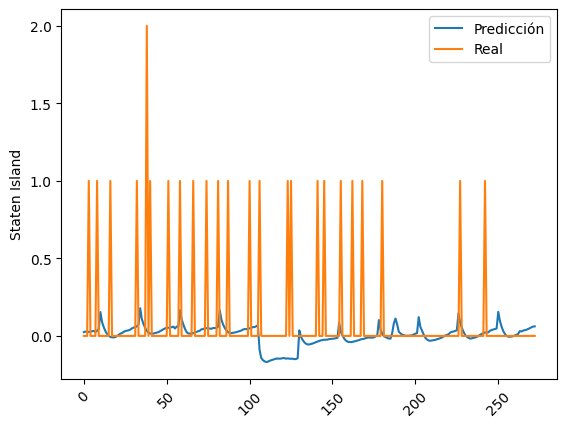

In [64]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y )

Valor final de Loss: 0.020634107291698456


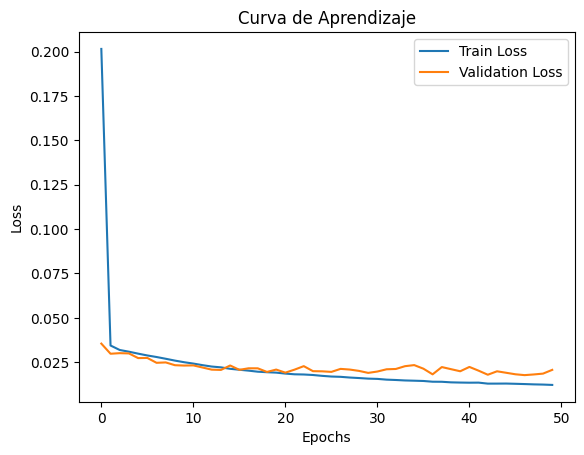

In [65]:
graficar_curva_aprendizaje(history)

In [66]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history = construir_modelo_cv(
    X, Y, nro_pasos=5, nro_capas_lstm=1, act_lstm= 'sigmoid', scaler='minmax',
    learning_r=0.001, epochs=50
)
np.mean(-scores)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 50)                12200     
                                                                 
 dropout_38 (Dropout)        (None, 50)                0         
                                                                 
 dense_30 (Dense)            (None, 5)                 255       
                                                                 
Total params: 12455 (48.65 KB)
Trainable params: 12455 (48.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 50)                12200     
                                                            

0.02119916390659147

Valor final de Loss: 0.020178811624646187


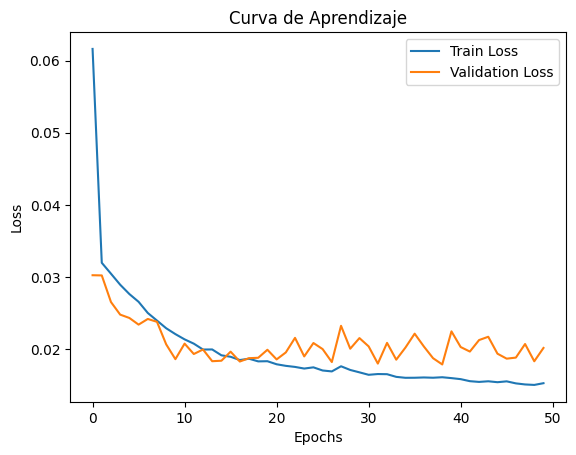

In [67]:
graficar_curva_aprendizaje(history)

9/9 [==============================] - 0s 3ms/step


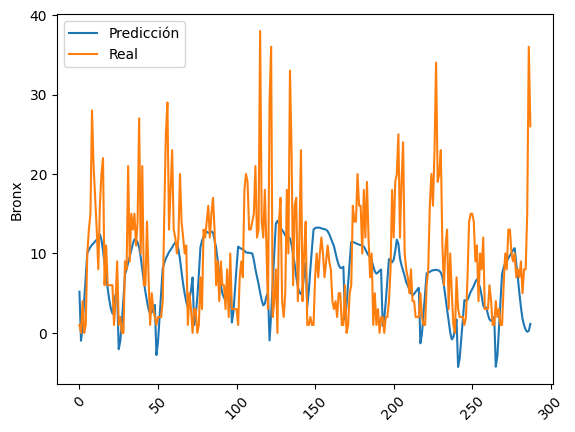

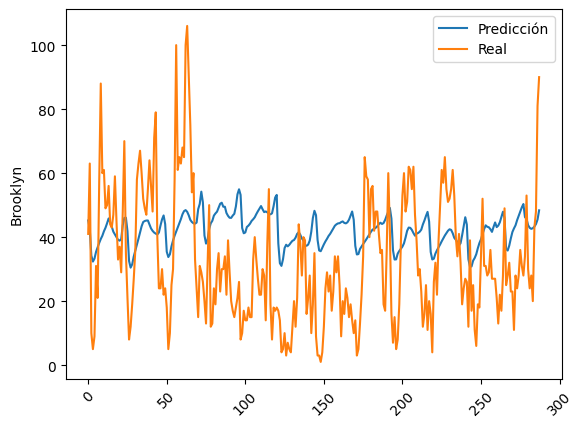

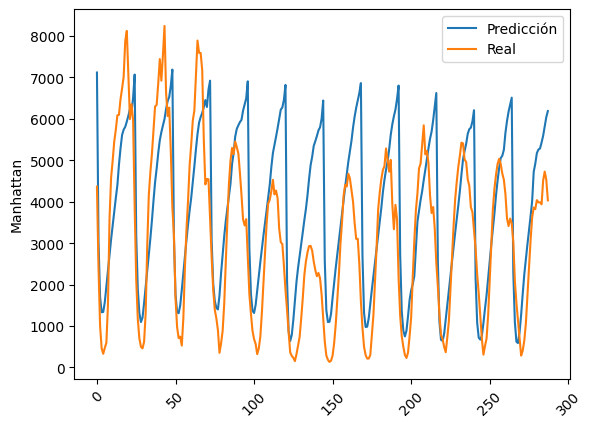

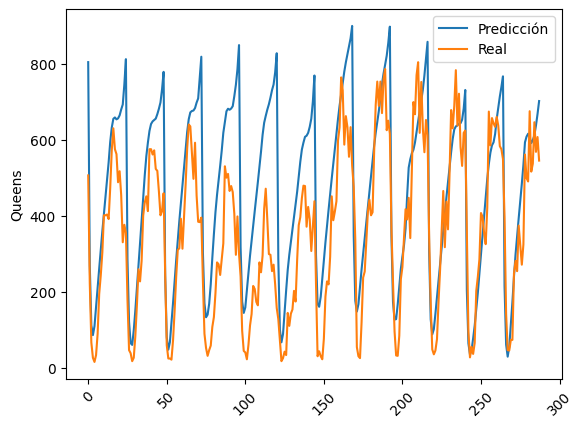

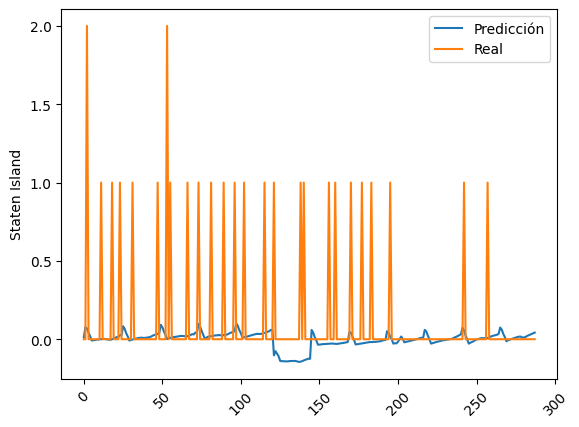

In [68]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y )

In [69]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history = construir_modelo_cv(
    X, Y, nro_pasos=5, nro_capas_lstm=1, act_lstm= 'sigmoid', scaler='minmax',
    learning_r=0.0001, epochs=100
)
np.mean(-scores)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 50)                12200     
                                                                 
 dropout_44 (Dropout)        (None, 50)                0         
                                                                 
 dense_36 (Dense)            (None, 5)                 255       
                                                                 
Total params: 12455 (48.65 KB)
Trainable params: 12455 (48.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 50)                12200     
                                                            

0.027620105466752913

Valor final de Loss: 0.019767524674534798


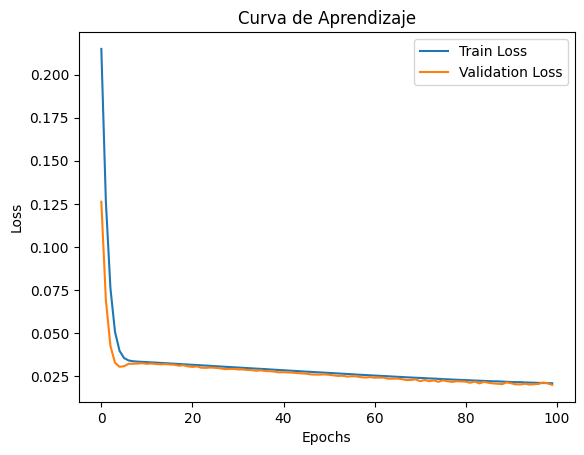

In [70]:
graficar_curva_aprendizaje(history)

9/9 [==============================] - 0s 2ms/step


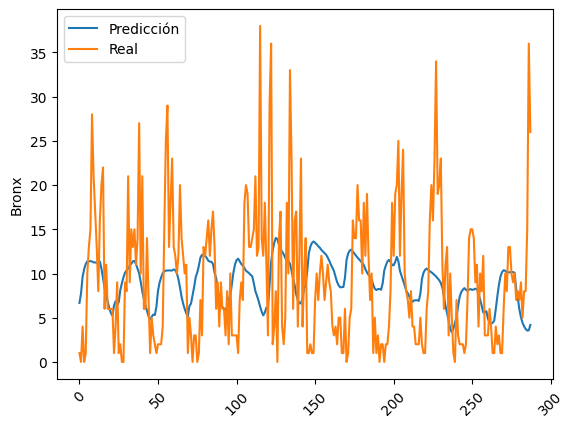

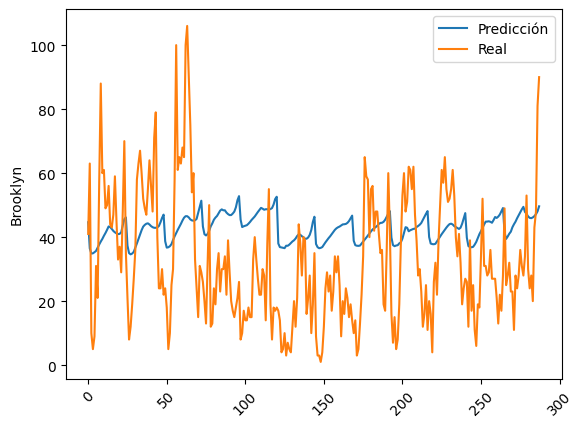

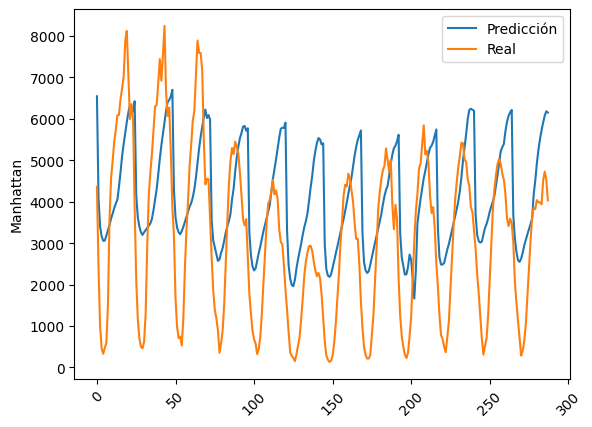

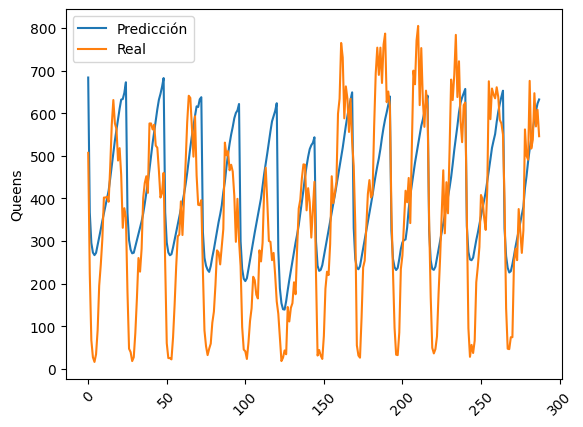

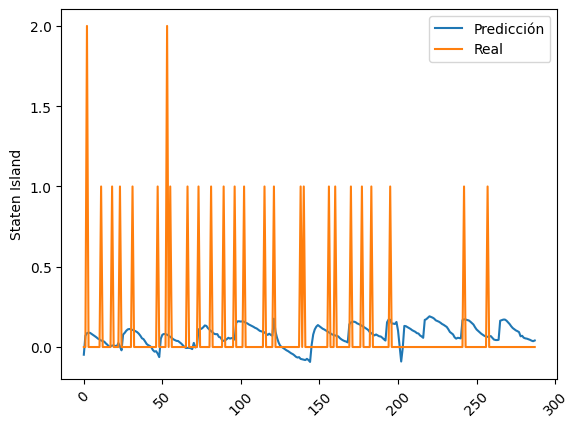

In [71]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y )

In [91]:
df_eval = evaluar_modelos(X,Y,nro_pasos=3,nro_capas_lstm=[1,2], unidades_capa=[50,30])

10/10 [==============================] - 0s 2ms/step - loss: 0.0140
Finalizada combinación 1 de 12. Score= 0.02
Mejor combinación: 1. Score: 0.02
10/10 [==============================] - 0s 2ms/step
Finalizada combinación 2 de 12. Score= 0.017
Mejor combinación: 2. Score: 0.017
10/10 [==============================] - 0s 6ms/step - loss: 0.0204
Finalizada combinación 3 de 12. Score= 0.024
Mejor combinación: 2. Score: 0.017
10/10 [==============================] - 0s 2ms/step
Finalizada combinación 4 de 12. Score= 0.018
Mejor combinación: 2. Score: 0.017
10/10 [==============================] - 0s 4ms/step - loss: 0.0317
Finalizada combinación 5 de 12. Score= 0.027
Mejor combinación: 2. Score: 0.017
10/10 [==============================] - 0s 2ms/step
Finalizada combinación 6 de 12. Score= 0.025
Mejor combinación: 2. Score: 0.017
10/10 [==============================] - 0s 6ms/step - loss: 0.0153
Finalizada combinación 7 de 12. Score= 0.03
Mejor combinación: 2. Score: 0.017
10/10 [=====

In [93]:
df_eval.sort_values(by='cv_scores_mean')

,combinacion,nro_pasos,nro_capas_lstm,unidades_capa,loss_function,act_salida,act_lstm,loss_value(mse),cv_scores_mean,tiempo(s)
1,2,1,1,50,mae,linear,relu,0.012005,0.017402,25.865024
3,4,1,2,"50, 30",mae,linear,relu,0.042916,0.017614,65.620374
0,1,1,1,50,mse,linear,relu,0.014008,0.020451,30.850785
8,9,3,1,50,mse,linear,relu,0.016273,0.020648,38.622546
2,3,1,2,"50, 30",mse,linear,relu,0.020367,0.024225,51.497537
5,6,2,1,50,mae,linear,relu,0.020283,0.024683,32.269175
10,11,3,2,"50, 30",mse,linear,relu,0.032546,0.025834,82.913762
4,5,2,1,50,mse,linear,relu,0.031717,0.027479,68.470565
6,7,2,2,"50, 30",mse,linear,relu,0.015261,0.030440,54.481554
9,10,3,1,50,mae,linear,relu,0.035563,0.032623,42.713341


Ahora vamos a construir el modelo que salió mejor:

In [95]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss = construir_modelo_cv(X, Y, nro_pasos=1, nro_capas_lstm=1, 
                                                                                        unidades_capa=[50], loss_='mae', act_lstm='relu',
                                                                                        act_salida='linear')

10/10 [==============================] - 0s 2ms/step


Valor final de Loss: 0.08397645503282547


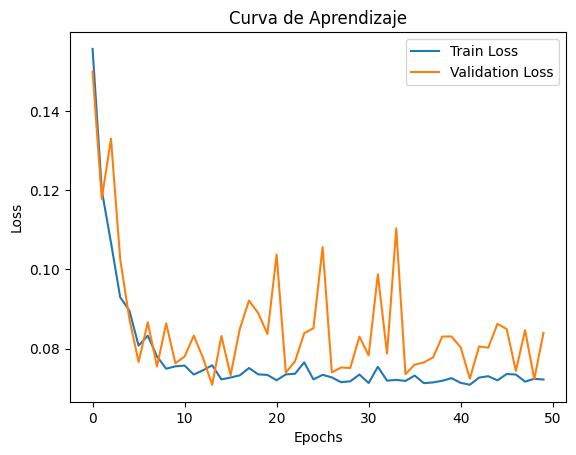

In [97]:
graficar_curva_aprendizaje(history)

Vemos que el modelo no converge correctamente en el entrenamiento. Cambiemos la tasa de aprendizaje:

10/10 [==============================] - 0s 1ms/step
Valor final de Loss: 0.10570354759693146


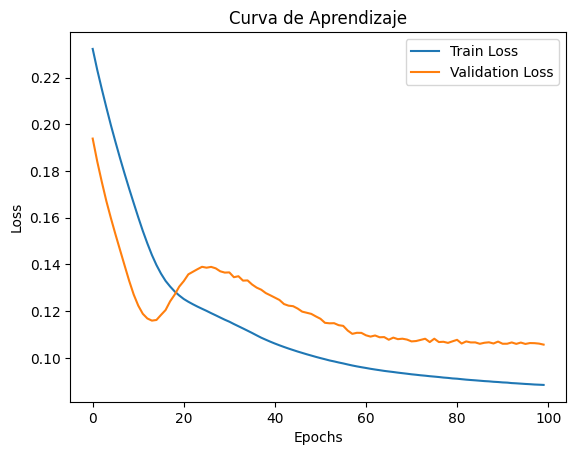

In [101]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss = construir_modelo_cv(X, Y, nro_pasos=1, nro_capas_lstm=1, 
                                                                                        unidades_capa=[50], loss_='mae', act_lstm='relu',
                                                                                        act_salida='linear', learning_r=0.0001, epochs=100)
graficar_curva_aprendizaje(history)

Evaluemos nuevamente, con más combinaciones:

In [102]:
df_eval = evaluar_modelos(X,Y,nro_pasos=5,nro_capas_lstm=[1,2], unidades_capa=[50,30], act_lstm=['relu', 'sigmoid'], act_salida=['relu', 'linear', 'sigmoid'])

10/10 [==============================] - 0s 0s/step - loss: 0.0186
Finalizada combinación 1 de 120. Score= 0.028
Mejor combinación: 1. Score: 0.028
10/10 [==============================] - 0s 2ms/step - loss: 0.0555
Finalizada combinación 2 de 120. Score= 0.078
Mejor combinación: 1. Score: 0.028
10/10 [==============================] - 0s 1ms/step - loss: 0.0204
Finalizada combinación 3 de 120. Score= 0.02
Mejor combinación: 3. Score: 0.02
10/10 [==============================] - 0s 10ms/step - loss: 0.0199
Finalizada combinación 4 de 120. Score= 0.023
Mejor combinación: 3. Score: 0.02
10/10 [==============================] - 0s 2ms/step - loss: 0.0171
Finalizada combinación 5 de 120. Score= 0.022
Mejor combinación: 3. Score: 0.02
10/10 [==============================] - 0s 2ms/step - loss: 0.0199
Finalizada combinación 6 de 120. Score= 0.026
Mejor combinación: 3. Score: 0.02
10/10 [==============================] - 0s 1ms/step
Finalizada combinación 7 de 120. Score= 0.029
Mejor combin

In [104]:
df_eval.sort_values(by='cv_scores_mean')

,combinacion,nro_pasos,nro_capas_lstm,unidades_capa,loss_function,act_salida,act_lstm,loss_value(mse),cv_scores_mean,tiempo(s)
118,119,5,2,"50, 30",mae,sigmoid,relu,0.017869,0.015131,41.797293
70,71,3,2,"50, 30",mae,sigmoid,relu,0.012675,0.015171,86.127129
68,69,3,2,"50, 30",mae,linear,relu,0.016570,0.016047,34.487502
44,45,2,2,"50, 30",mae,linear,relu,0.019642,0.016110,30.804859
62,63,3,2,"50, 30",mse,linear,relu,0.023532,0.016142,90.362791
...,...,...,...,...,...,...,...,...,...,...
91,92,4,2,"50, 30",mae,relu,sigmoid,0.033887,0.073573,44.357676
19,20,1,2,"50, 30",mae,relu,sigmoid,0.076828,0.075975,29.491852
13,14,1,2,"50, 30",mse,relu,sigmoid,0.080380,0.076606,28.125607
1,2,1,1,50,mse,relu,sigmoid,0.055517,0.077681,18.081091


Construyamos el mejor modelo:

9/9 [==============================] - 0s 2ms/step
Valor final de Loss: 0.10378260910511017


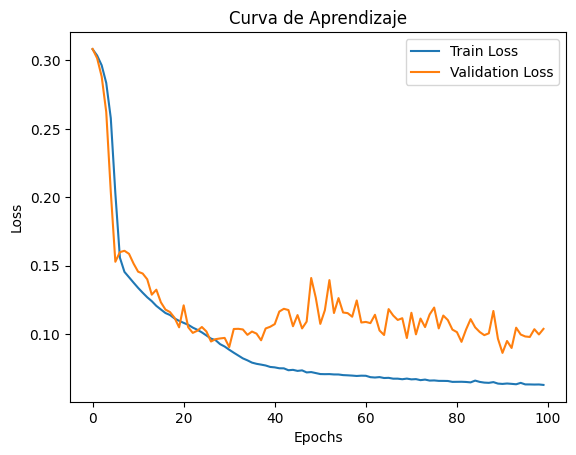

In [105]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss = construir_modelo_cv(X, Y, nro_pasos=5, nro_capas_lstm=2, 
                                                                                        unidades_capa=[50, 30], loss_='mae', act_lstm='relu',
                                                                                        act_salida='sigmoid', learning_r=0.0001, epochs=100)
graficar_curva_aprendizaje(history)

9/9 [==============================] - 0s 3ms/step


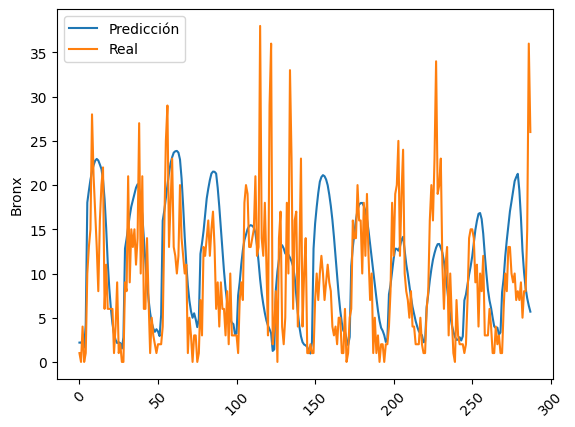

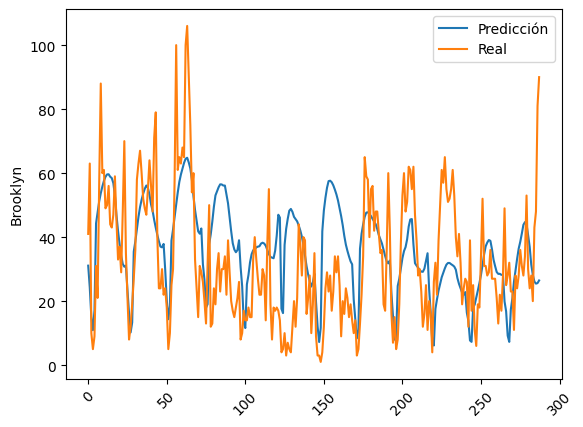

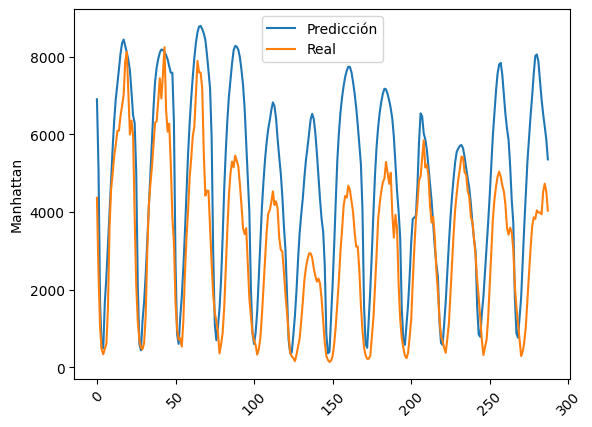

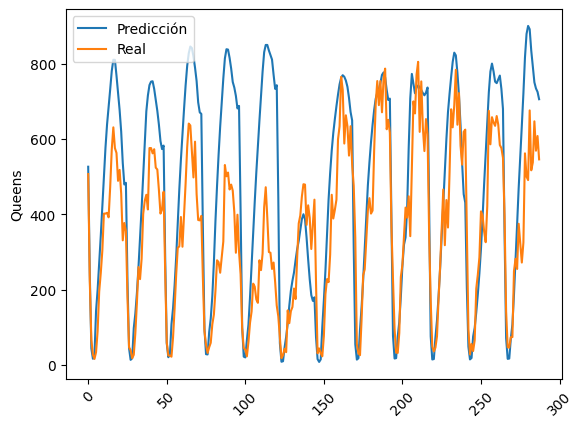

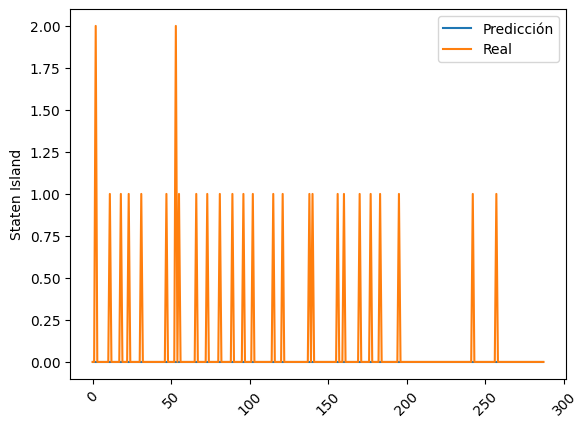

In [106]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y)

Bajemos el learning rate y aumentemos las epochs:

9/9 [==============================] - 0s 1ms/step
Valor final de Loss: 0.13084112107753754


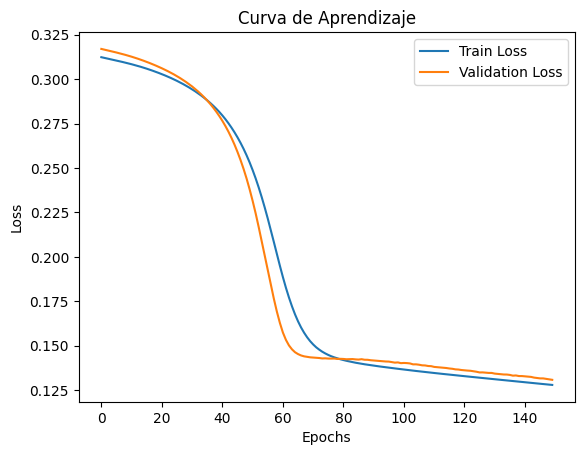

In [107]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss = construir_modelo_cv(X, Y, nro_pasos=5, nro_capas_lstm=2, 
                                                                                        unidades_capa=[50, 30], loss_='mae', act_lstm='relu',
                                                                                        act_salida='sigmoid', learning_r=0.00001, epochs=150)
graficar_curva_aprendizaje(history)

9/9 [==============================] - 0s 1ms/step
Valor final de Loss: 0.07179346680641174


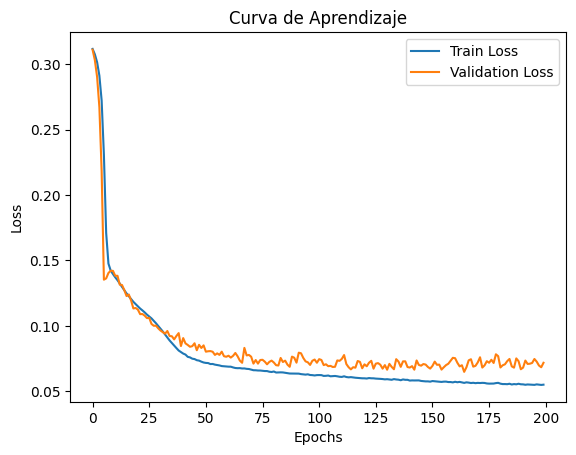

In [108]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss = construir_modelo_cv(X, Y, nro_pasos=5, nro_capas_lstm=2, 
                                                                                        unidades_capa=[50, 30], loss_='mae', act_lstm='relu',
                                                                                        act_salida='sigmoid', learning_r=0.0001, epochs=200)
graficar_curva_aprendizaje(history)

9/9 [==============================] - 0s 3ms/step


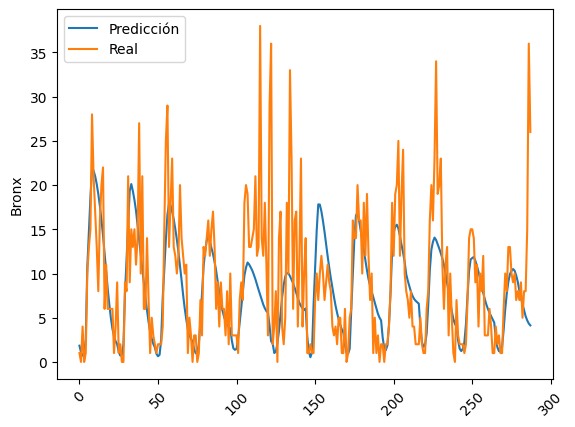

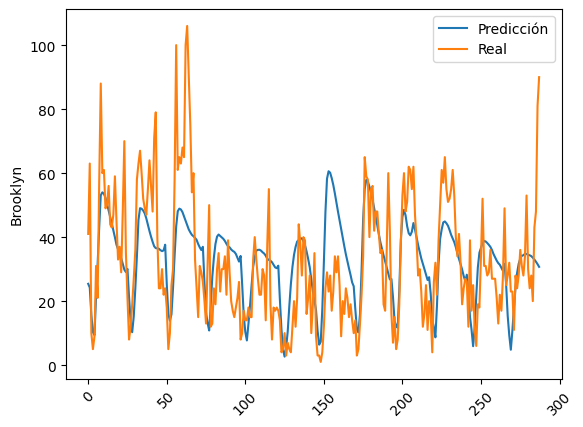

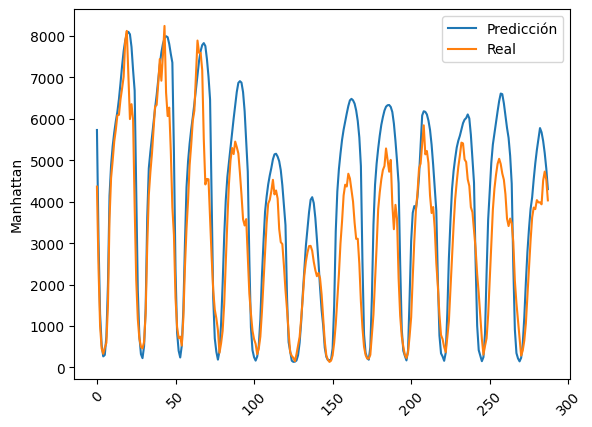

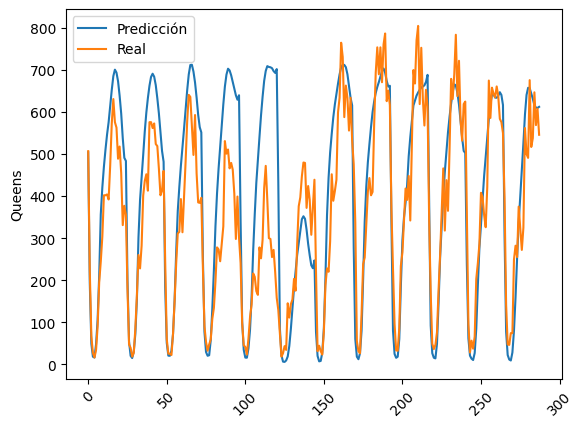

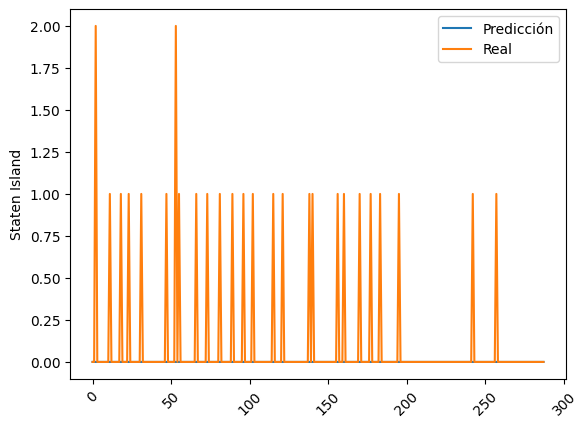

In [109]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y)

Agreguemos más neuronas en la segunda capa

9/9 [==============================] - 1s 4ms/step
Valor final de Loss: 0.07996129244565964


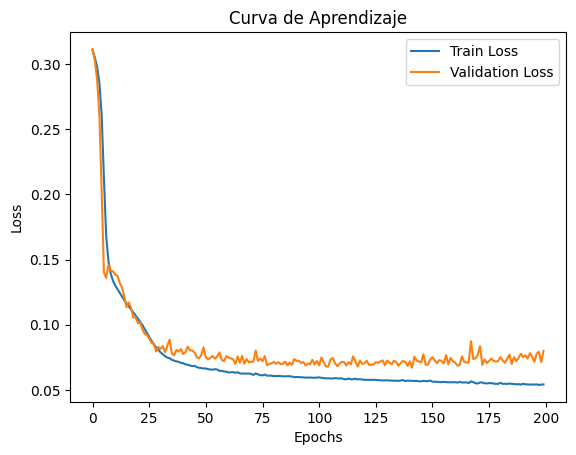

In [13]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss = construir_modelo_cv(X, Y, nro_pasos=5, nro_capas_lstm=2, 
                                                                                        unidades_capa=[50, 40], loss_='mae', act_lstm='relu',
                                                                                        act_salida='sigmoid', learning_r=0.0001, epochs=200)
graficar_curva_aprendizaje(history)

9/9 [==============================] - 0s 2ms/step


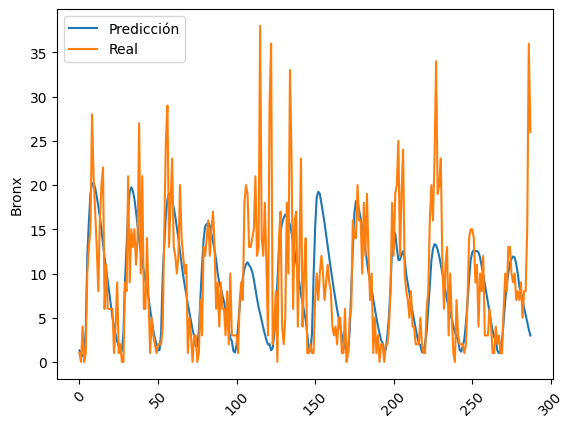

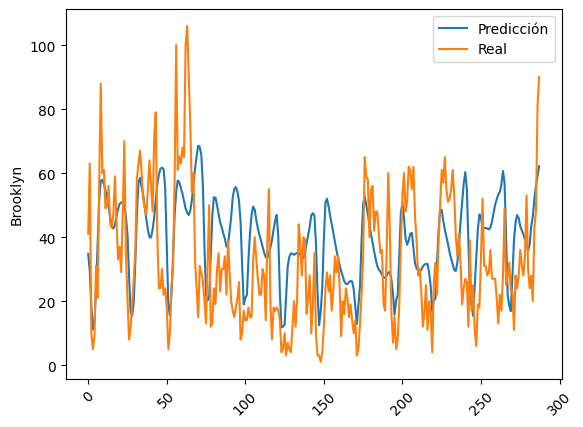

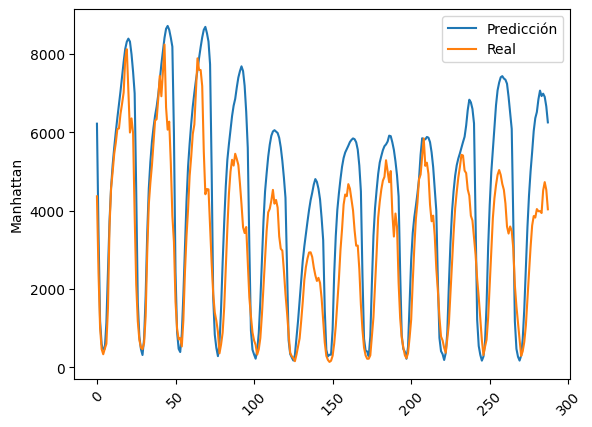

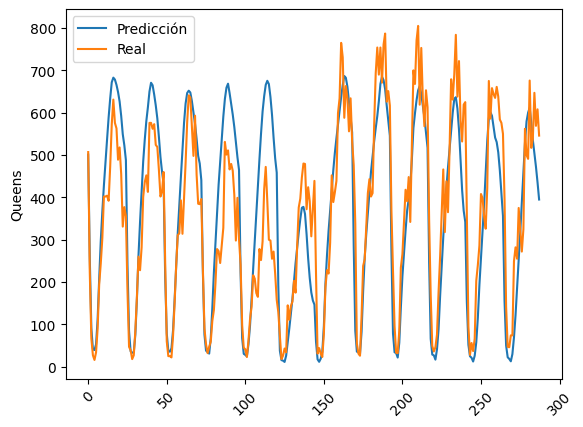

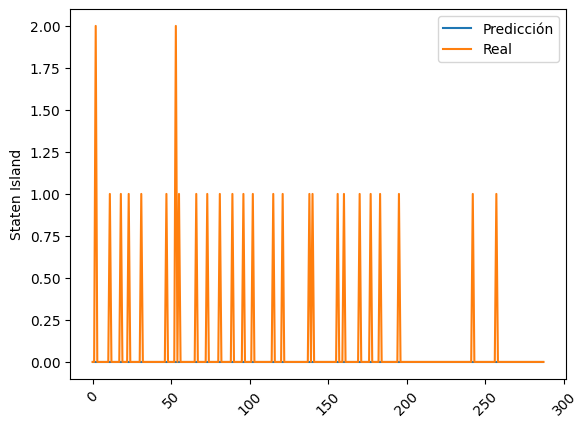

In [15]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y)

Hagamos una nueva evaluación, solamente variando el número de pasos

In [16]:
df_eval = evaluar_modelos(X,Y,nro_pasos=25,nro_capas_lstm=[2], unidades_capa=[50,40])

10/10 [==============================] - 0s 2ms/step - loss: 0.0188
Finalizada combinación 1 de 50. Score= 0.019
Mejor combinación: 1. Score: 0.019
Quedan 38.02016361157099 minutos.
10/10 [==============================] - 0s 2ms/step
Finalizada combinación 2 de 50. Score= 0.019
Mejor combinación: 1. Score: 0.019
Quedan 28.466897678375243 minutos.
10/10 [==============================] - 0s 2ms/step - loss: 0.0303
Finalizada combinación 3 de 50. Score= 0.018
Mejor combinación: 3. Score: 0.018
Quedan 26.798246167765726 minutos.
10/10 [==============================] - 0s 1ms/step
Finalizada combinación 4 de 50. Score= 0.017
Mejor combinación: 4. Score: 0.017
Quedan 25.7196972767512 minutos.
10/10 [==============================] - 0s 2ms/step - loss: 0.0235
Finalizada combinación 5 de 50. Score= 0.017
Mejor combinación: 5. Score: 0.017
Quedan 25.122785460948943 minutos.
10/10 [==============================] - 0s 1ms/step
Finalizada combinación 6 de 50. Score= 0.018
Mejor combinación: 5

In [19]:
df_eval.sort_values(by='cv_scores_mean')

,combinacion,nro_pasos,nro_capas_lstm,unidades_capa,loss_function,act_salida,act_lstm,loss_value(mse),cv_scores_mean,tiempo(s)
4,5,3,2,"50, 40",mse,linear,relu,0.023494,0.016743,33.295511
19,20,10,2,"50, 40",mae,linear,relu,0.018315,0.016911,58.248427
18,19,10,2,"50, 40",mse,linear,relu,0.018177,0.017044,57.576712
3,4,2,2,"50, 40",mae,linear,relu,0.018809,0.017152,31.558144
16,17,9,2,"50, 40",mse,linear,relu,0.021064,0.017274,54.128383
14,15,8,2,"50, 40",mse,linear,relu,0.019839,0.017284,63.539447
13,14,7,2,"50, 40",mae,linear,relu,0.015655,0.017456,62.465721
5,6,3,2,"50, 40",mae,linear,relu,0.017320,0.017753,33.217794
9,10,5,2,"50, 40",mae,linear,relu,0.021442,0.017829,40.052154
45,46,23,2,"50, 40",mae,linear,relu,0.021925,0.018024,130.353798


10/10 [==============================] - 0s 6ms/step - loss: 0.0197
Valor final de Loss: 0.019656546413898468


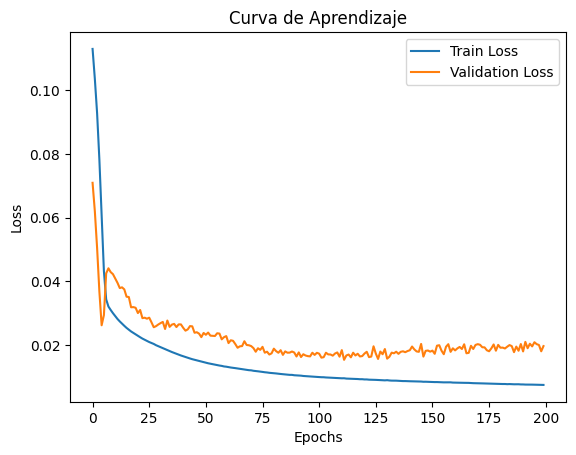

In [20]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss = construir_modelo_cv(X, Y, nro_pasos=3, nro_capas_lstm=2, 
                                                                                        unidades_capa=[50, 40], loss_='mse', act_lstm='relu',
                                                                                        act_salida='linear', learning_r=0.0001, epochs=200)
graficar_curva_aprendizaje(history)

10/10 [==============================] - 1s 5ms/step


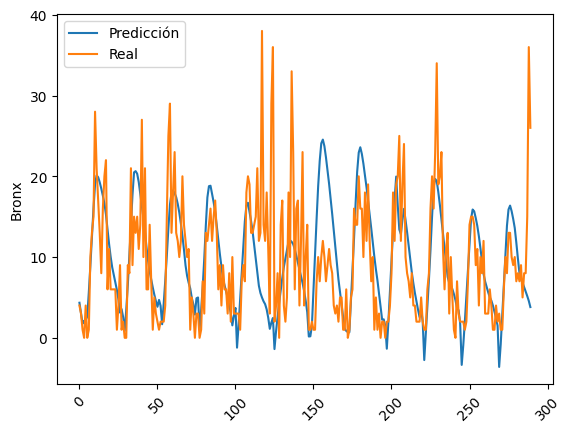

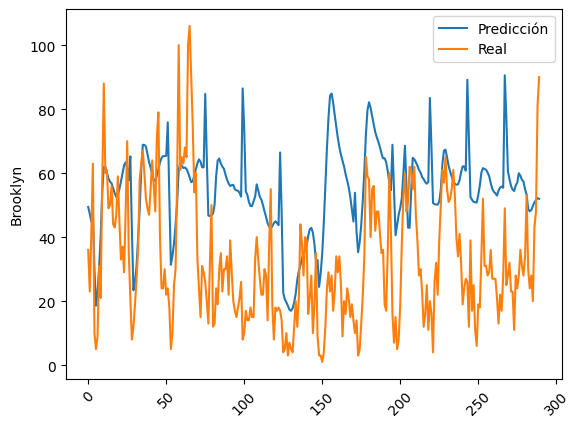

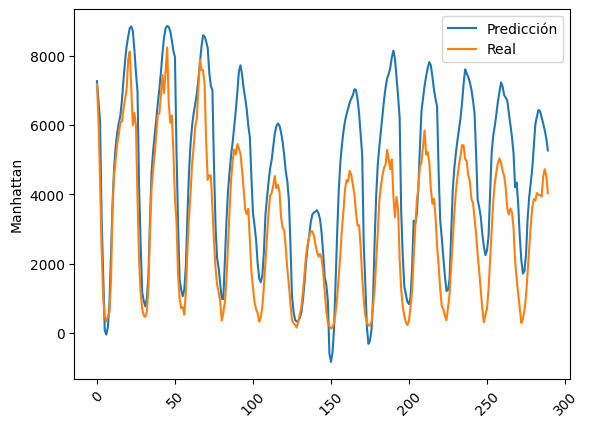

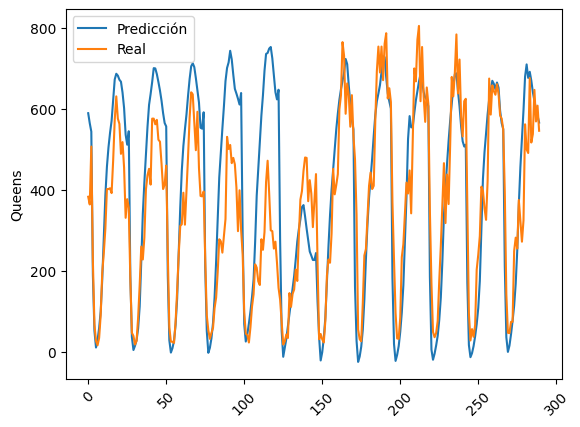

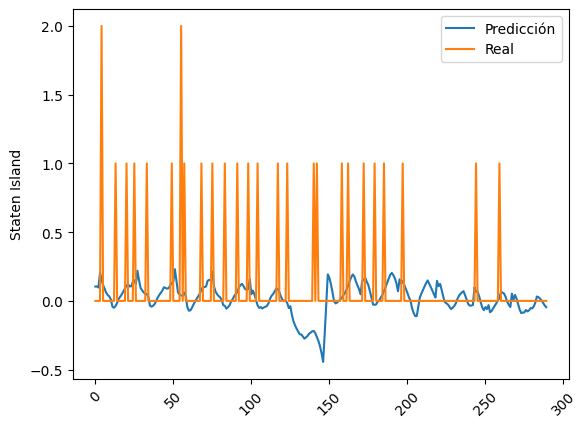

In [21]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y)

Probemos agregando mas capas dense:

In [40]:
df_eval = evaluar_modelos(X,Y,nro_pasos=2,nro_capas_lstm=[2], unidades_capa=[50,40], nro_capas_dense=1, unidades_dense=[40])

10/10 [==============================] - 0s 4ms/step - loss: 0.0258
Finalizada combinación 1 de 4. Score= 0.018
Mejor combinación: 1. Score: 0.018
Quedan 1.4 minutos.
10/10 [==============================] - 0s 2ms/step
Finalizada combinación 2 de 4. Score= 0.019
Mejor combinación: 1. Score: 0.018
Quedan 1.56 minutos.
10/10 [==============================] - 0s 2ms/step - loss: 0.0185
Finalizada combinación 3 de 4. Score= 0.017
Mejor combinación: 3. Score: 0.017
Quedan 0.74 minutos.
10/10 [==============================] - 0s 2ms/step
Finalizada combinación 4 de 4. Score= 0.017
Mejor combinación: 4. Score: 0.017
Quedan 0.0 minutos.


In [41]:
df_eval

,combinacion,nro_pasos,nro_capas_lstm,unidades_capa,nro_capas_dense,unidades_dense,loss_function,act_salida,act_lstm,act_dense,loss_value(mse),cv_scores_mean,tiempo(s)
0,1,1,2,"50, 40",1,40,mse,linear,relu,linear,0.025830,0.017901,27.990340
1,2,1,2,"50, 40",1,40,mae,linear,relu,linear,0.018313,0.018816,65.537866
2,3,2,2,"50, 40",1,40,mse,linear,relu,linear,0.018466,0.017356,39.701928
3,4,2,2,"50, 40",1,40,mae,linear,relu,linear,0.018114,0.016864,38.905261


In [42]:
df_eval.sort_values(by='cv_scores_mean')

,combinacion,nro_pasos,nro_capas_lstm,unidades_capa,nro_capas_dense,unidades_dense,loss_function,act_salida,act_lstm,act_dense,loss_value(mse),cv_scores_mean,tiempo(s)
3,4,2,2,"50, 40",1,40,mae,linear,relu,linear,0.018114,0.016864,38.905261
2,3,2,2,"50, 40",1,40,mse,linear,relu,linear,0.018466,0.017356,39.701928
0,1,1,2,"50, 40",1,40,mse,linear,relu,linear,0.025830,0.017901,27.990340
1,2,1,2,"50, 40",1,40,mae,linear,relu,linear,0.018313,0.018816,65.537866


Ya vemos que las modificaciones funcionan.